# Logits to Normal Distribution

In [1]:
import os
import sys
import math
import time
import random
import tempfile
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import softmax

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.distributions import MultivariateNormal

In [2]:
%matplotlib inline

In [3]:
n_samples = 1500
dim = 3

PI = torch.Tensor([math.pi])

## Base distribution, Uncalibrated Logits

In [4]:
target = np.array(random.choices(range(3), k=n_samples))
one_hot = np.zeros((n_samples, 3))
one_hot[np.arange(n_samples), target] = 1.

# Shift
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.05

# Twist
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), target-1] = 0.7 + np.random.randn(n_samples)*0.1

logits = np.float32(0.8 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.3) + offset)

# Equivalent to log(softmax())
logits -= np.log(np.sum(np.exp(logits), axis=1, keepdims=True))

probs = softmax(logits, axis=1)

# Convert data to torch tensors.
torch_logits = torch.as_tensor(logits, dtype=torch.float)
torch_target = torch.as_tensor(target, dtype=torch.long)


## Define Flows

In [5]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_size=[], activation=F.relu):
        super(MLP, self).__init__()
        self.activation = activation
        units = [dim] + hidden_size + [dim]
        self.layers = nn.ModuleList([nn.Linear(units[i], units[i+1])
                                     for i in range(len(units)-1)])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        y = self.layers[-1](x)

        return y

In [6]:
class AffineConstantLayer(nn.Module):

    def __init__(self, dim, scale=True, shift=True):
        super(AffineConstantLayer, self).__init__()

        self.s = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if scale else None
        self.t = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if shift else None

    def forward(self, x):
        s = self.s if self.s is not None else x.new_zeros(x.size())
        t = self.t if self.t is not None else x.new_zeros(x.size())
        z = x * torch.exp(s) + t
        log_det = torch.sum(s, dim=1)
        return z, log_det

    def backward(self, z):
        s = self.s if self.s is not None else z.new_zeros(z.size())
        t = self.t if self.t is not None else z.new_zeros(z.size())
        x = (z - t) * torch.exp(-s)
        log_det = torch.sum(-s, dim=1)
        return x, log_det

In [7]:
class NvpCouplingLayer(nn.Module):
    def __init__(self, dim, hidden_size=[5, 5], random_mask=True):
        super(NvpCouplingLayer, self).__init__()
        self.s = MLP(dim, hidden_size)
        self.t = MLP(dim, hidden_size)
        
        # Use random partitioning of the data
        mask = np.random.randint(2, size=dim)
        if random_mask:
            while mask.sum() < 1 or mask.sum() == dim:
                mask = np.random.randint(2, size=dim)
        else:
            mask = np.zeros((1, dim))
            mask[:, dim//2:] = 1
            
        self.mask = nn.Parameter(
                torch.as_tensor(mask.copy(), dtype=torch.float),
                requires_grad=False)

    def forward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1 * (x * torch.exp(s) + t)

        log_det = torch.sum(b_1*s, dim=1)

        return y.flip((1,)), log_det.squeeze()

    def backward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1*((x - t) * torch.exp(-s))

        log_det = torch.sum(b_1*(-s), dim=1)

        return y.flip((1,)), log_det.squeeze()

In [8]:
class Flow(nn.Module):
    def __init__(self, layers, **kwargs):
        super(Flow, self).__init__()

        self.layers = nn.ModuleList(layers)
        self.log_det = nn.Parameter(torch.zeros(1), requires_grad=False)

    def forward(self, x):
        cum_log_det = self.log_det.new_full((x.shape[0],), fill_value=0)
        for layer in self.layers:
            x, log_det = layer(x)
            cum_log_det += log_det
            
        return x, cum_log_det
            
    def backward(self, x):
        cum_log_det = self.log_det.new_full((x.shape[0],), fill_value=0)
        for layer in self.layers[::-1]:
            x, log_det = layer.backward(x)
            cum_log_det += log_det

        return x, cum_log_det

## Create flow

In [9]:
model = Flow(layers=[NvpCouplingLayer(dim, [5, 5], random_mask=False) for _ in range(15)])
dev = torch.device('cpu')

## Train flow

In [10]:
epochs = 10000

In [11]:
model = model.to(dev, non_blocking=True)

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss = []
logprior = []
logdet = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = torch.zeros(1, device=dev)
    cum_logdet = torch.zeros(1, device=dev)
    cum_logprior = torch.zeros(1, device=dev)

    optimizer.zero_grad()

    preds, _logdet = model(torch_logits)

    _logdet = torch.mean(_logdet)
    _logprior = -torch.mean(-0.5 * (3.0 * torch.log(2*PI) + torch.sum(torch.pow(preds, 2), dim=1)))
    _loss = _logprior - _logdet

    _loss.backward()
    optimizer.step()

    loss.append(_loss.item())
    logprior.append(_logprior.item())
    logdet.append(_logdet.item())

    if e%10 == 9:
        print('epoch: {}, at time: {:.2f}, loss: {:.3f}'.format(e, time.time()-t0, loss[-1]))

epoch: 9, at time: 1.22, loss: 8.718
epoch: 19, at time: 2.08, loss: 8.575
epoch: 29, at time: 3.00, loss: 8.439
epoch: 39, at time: 3.98, loss: 8.310
epoch: 49, at time: 4.94, loss: 8.187
epoch: 59, at time: 5.86, loss: 8.070
epoch: 69, at time: 6.86, loss: 7.958
epoch: 79, at time: 7.78, loss: 7.850
epoch: 89, at time: 8.64, loss: 7.746
epoch: 99, at time: 9.45, loss: 7.645
epoch: 109, at time: 10.39, loss: 7.546
epoch: 119, at time: 11.36, loss: 7.450
epoch: 129, at time: 12.25, loss: 7.356
epoch: 139, at time: 13.15, loss: 7.264
epoch: 149, at time: 14.06, loss: 7.172
epoch: 159, at time: 15.05, loss: 7.082
epoch: 169, at time: 15.94, loss: 6.993
epoch: 179, at time: 16.82, loss: 6.905
epoch: 189, at time: 17.72, loss: 6.817
epoch: 199, at time: 18.70, loss: 6.731
epoch: 209, at time: 19.66, loss: 6.646
epoch: 219, at time: 20.72, loss: 6.562
epoch: 229, at time: 21.78, loss: 6.479
epoch: 239, at time: 22.86, loss: 6.399
epoch: 249, at time: 23.83, loss: 6.320
epoch: 259, at time: 

epoch: 2009, at time: 197.59, loss: -1.748
epoch: 2019, at time: 198.64, loss: -1.743
epoch: 2029, at time: 199.64, loss: -1.755
epoch: 2039, at time: 200.63, loss: -1.765
epoch: 2049, at time: 201.56, loss: -1.772
epoch: 2059, at time: 202.55, loss: -1.778
epoch: 2069, at time: 203.55, loss: -1.786
epoch: 2079, at time: 204.61, loss: -1.771
epoch: 2089, at time: 205.53, loss: -1.794
epoch: 2099, at time: 206.55, loss: -1.803
epoch: 2109, at time: 207.53, loss: -1.803
epoch: 2119, at time: 208.53, loss: -1.810
epoch: 2129, at time: 209.58, loss: -1.810
epoch: 2139, at time: 210.52, loss: -1.825
epoch: 2149, at time: 211.54, loss: -1.830
epoch: 2159, at time: 212.49, loss: -1.832
epoch: 2169, at time: 213.56, loss: -1.834
epoch: 2179, at time: 214.58, loss: -1.844
epoch: 2189, at time: 215.51, loss: -1.842
epoch: 2199, at time: 216.53, loss: -1.848
epoch: 2209, at time: 217.52, loss: -1.855
epoch: 2219, at time: 218.48, loss: -1.860
epoch: 2229, at time: 219.51, loss: -1.864
epoch: 2239

epoch: 3919, at time: 390.88, loss: -2.258
epoch: 3929, at time: 391.89, loss: -2.265
epoch: 3939, at time: 392.93, loss: -2.269
epoch: 3949, at time: 393.95, loss: -2.264
epoch: 3959, at time: 395.02, loss: -2.273
epoch: 3969, at time: 396.03, loss: -2.264
epoch: 3979, at time: 397.07, loss: -2.276
epoch: 3989, at time: 398.08, loss: -2.276
epoch: 3999, at time: 399.06, loss: -2.276
epoch: 4009, at time: 399.96, loss: -2.277
epoch: 4019, at time: 400.97, loss: -2.285
epoch: 4029, at time: 402.07, loss: -2.287
epoch: 4039, at time: 403.09, loss: -2.269
epoch: 4049, at time: 404.09, loss: -2.286
epoch: 4059, at time: 405.10, loss: -2.293
epoch: 4069, at time: 406.03, loss: -2.288
epoch: 4079, at time: 406.95, loss: -2.296
epoch: 4089, at time: 407.78, loss: -2.298
epoch: 4099, at time: 408.71, loss: -2.294
epoch: 4109, at time: 409.79, loss: -2.303
epoch: 4119, at time: 410.78, loss: -2.305
epoch: 4129, at time: 411.78, loss: -2.309
epoch: 4139, at time: 412.75, loss: -2.308
epoch: 4149

epoch: 5829, at time: 587.35, loss: -2.622
epoch: 5839, at time: 588.39, loss: -2.640
epoch: 5849, at time: 589.40, loss: -2.639
epoch: 5859, at time: 590.44, loss: -2.639
epoch: 5869, at time: 591.47, loss: -2.648
epoch: 5879, at time: 592.45, loss: -2.630
epoch: 5889, at time: 593.36, loss: -2.642
epoch: 5899, at time: 594.45, loss: -2.646
epoch: 5909, at time: 595.52, loss: -2.654
epoch: 5919, at time: 596.67, loss: -2.657
epoch: 5929, at time: 597.80, loss: -2.659
epoch: 5939, at time: 598.81, loss: -2.607
epoch: 5949, at time: 599.85, loss: -2.644
epoch: 5959, at time: 600.81, loss: -2.654
epoch: 5969, at time: 601.88, loss: -2.665
epoch: 5979, at time: 602.87, loss: -2.654
epoch: 5989, at time: 603.91, loss: -2.665
epoch: 5999, at time: 604.94, loss: -2.669
epoch: 6009, at time: 605.97, loss: -2.667
epoch: 6019, at time: 606.85, loss: -2.672
epoch: 6029, at time: 607.82, loss: -2.676
epoch: 6039, at time: 608.82, loss: -2.676
epoch: 6049, at time: 609.76, loss: -2.679
epoch: 6059

epoch: 7739, at time: 783.09, loss: -2.924
epoch: 7749, at time: 784.09, loss: -2.914
epoch: 7759, at time: 785.07, loss: -2.934
epoch: 7769, at time: 786.03, loss: -2.933
epoch: 7779, at time: 787.01, loss: -2.929
epoch: 7789, at time: 788.03, loss: -2.939
epoch: 7799, at time: 789.19, loss: -2.925
epoch: 7809, at time: 790.27, loss: -2.927
epoch: 7819, at time: 791.31, loss: -2.924
epoch: 7829, at time: 792.38, loss: -2.926
epoch: 7839, at time: 793.42, loss: -2.936
epoch: 7849, at time: 794.45, loss: -2.942
epoch: 7859, at time: 795.46, loss: -2.942
epoch: 7869, at time: 796.48, loss: -2.935
epoch: 7879, at time: 797.58, loss: -2.924
epoch: 7889, at time: 798.58, loss: -2.926
epoch: 7899, at time: 799.72, loss: -2.922
epoch: 7909, at time: 800.72, loss: -2.933
epoch: 7919, at time: 801.79, loss: -2.949
epoch: 7929, at time: 802.88, loss: -2.911
epoch: 7939, at time: 803.95, loss: -2.955
epoch: 7949, at time: 805.04, loss: -2.945
epoch: 7959, at time: 806.04, loss: -2.951
epoch: 7969

epoch: 9649, at time: 980.35, loss: -3.070
epoch: 9659, at time: 981.20, loss: -3.066
epoch: 9669, at time: 982.20, loss: -3.065
epoch: 9679, at time: 983.30, loss: -3.081
epoch: 9689, at time: 984.11, loss: -3.068
epoch: 9699, at time: 985.12, loss: -3.079
epoch: 9709, at time: 986.09, loss: -3.075
epoch: 9719, at time: 986.99, loss: -3.081
epoch: 9729, at time: 988.01, loss: -3.068
epoch: 9739, at time: 989.00, loss: -3.083
epoch: 9749, at time: 990.09, loss: -3.075
epoch: 9759, at time: 991.09, loss: -3.078
epoch: 9769, at time: 992.03, loss: -3.073
epoch: 9779, at time: 992.95, loss: -3.065
epoch: 9789, at time: 993.98, loss: -3.081
epoch: 9799, at time: 995.01, loss: -3.082
epoch: 9809, at time: 995.95, loss: -3.081
epoch: 9819, at time: 996.94, loss: -3.086
epoch: 9829, at time: 997.94, loss: -3.064
epoch: 9839, at time: 998.94, loss: -3.073
epoch: 9849, at time: 999.72, loss: -3.090
epoch: 9859, at time: 1000.56, loss: -3.090
epoch: 9869, at time: 1001.53, loss: -3.074
epoch: 98

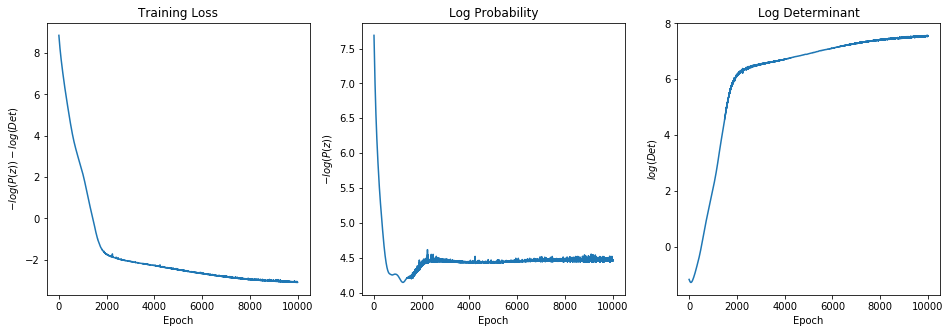

In [16]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(loss)
ax[1].plot(logprior)
ax[2].plot(logdet)


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$-log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

In [13]:
preds, _ = model(torch_logits)
preds = preds.detach().numpy()

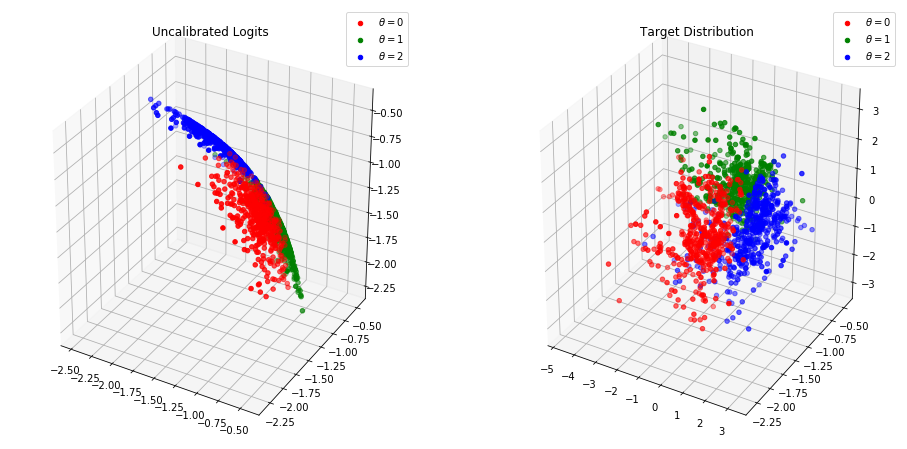

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

colors = ['r', 'g', 'b']

for i in range(3):
    ix = target==i
    ax1.scatter(logits[ix, 0], logits[ix, 1], logits[ix, 2], c=colors[i], label=r'$\theta={}$'.format(i))
    ax2.scatter(preds[ix, 0], preds[ix, 1], preds[ix, 2], c=colors[i], label=r'$\theta={}$'.format(i))

    
ax1.set_title('Uncalibrated Logits')
ax2.set_title('Target Distribution')
ax1.legend()
ax2.legend()
plt.show()